In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:

# 1. Load dataset from CSV
df= pd.read_csv('BTC-USD.csv')  
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3435,2024-02-12,48296.386719,50280.476563,47745.761719,49958.222656,49958.222656,34511985805
3436,2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
3437,2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
3438,2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533


In [9]:

# 2. Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3435,2024-02-12,48296.386719,50280.476563,47745.761719,49958.222656,49958.222656,34511985805
3436,2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
3437,2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
3438,2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533


In [10]:
# 3. Use 'Adj Close' as the base price
df['Price'] = df['Adj Close']

# 4. Calculate daily returns
df['Return'] = df['Price'].pct_change()

# 5. Calculate 7-day rolling volatility (standard deviation of returns)
df['Volatility'] = df['Return'].rolling(window=7).std()

In [11]:

# 6. Create lag features and moving averages
df['Return_1d'] = df['Return'].shift(1)
df['Return_2d'] = df['Return'].shift(2)
df['MA_7'] = df['Price'].rolling(window=7).mean()
df['MA_14'] = df['Price'].rolling(window=14).mean()

In [12]:
# 7. Log-transform volume to reduce skew
df['Log_Volume'] = np.log(df['Volume'])

In [13]:
# 8. Target variable: next-day volatility
df['Volatility_next'] = df['Volatility'].shift(-1)

In [14]:
# 9. Drop rows with missing values caused by shifts/rolling
df = df.dropna()

In [15]:
# 10. Define features and target
features = ['Return_1d', 'Return_2d', 'MA_7', 'MA_14', 'Log_Volume']
X = df[features]
y = df['Volatility_next']

In [16]:

# 11. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)  # No shuffle for time series


In [17]:
# 12. Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:

# 13. Predict on test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rmse:.6f}")

RMSE on test set: 0.017769


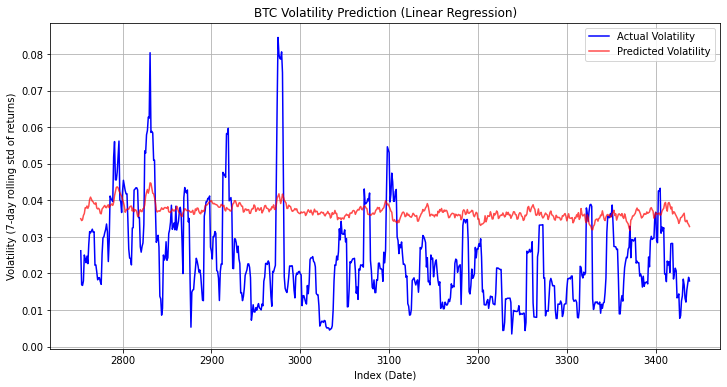

In [19]:
# 14. Plot actual vs predicted volatility
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Volatility', color='red', alpha=0.7)
plt.title('BTC Volatility Prediction (Linear Regression)')
plt.xlabel('Index (Date)')
plt.ylabel('Volatility (7-day rolling std of returns)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# 15. Print feature importance (coefficients)
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importances:")
print(coef_df)


Feature Importances:
      Feature  Coefficient
1   Return_2d    -0.005625
0   Return_1d    -0.005573
4  Log_Volume     0.001862
2        MA_7    -0.000002
3       MA_14     0.000001
